In [2]:
import csv
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt



In [45]:
df = pd.read_csv("C:/Users/Amy Le - PC/Documents/Consumer_Complaints.csv", low_memory = False)
###The dataset is collected from the consumer complaints database "

df = df[:10000]


Input: Complaints from customers in text "Consumer complaint narrative"
Output: Product. Ex: Credit card

Preprocessing



In [46]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

###Removing missing values in 'consumer complaint narrative' column
df=df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']

### Encode the 'product' column as an integer and add the encoded column
df['Product_id'] = df['Product'].factorize()[0]

print(df.shape)
top = df.head(10)
print(top)


(2102, 3)
             Product                       Consumer_complaint_narrative  \
1   Credit reporting  I have outdated information on my credit repor...   
2      Consumer Loan  I purchased a new car on XXXX XXXX. The car de...   
7   Credit reporting  An account on my credit report has a mistaken ...   
12   Debt collection  This company refuses to provide me verificatio...   
16   Debt collection  This complaint is in regards to Square Two Fin...   
25          Mortgage  Started the refinance of home mortgage process...   
26          Mortgage  In XXXX, I and my ex-husband applied for a ref...   
28  Credit reporting  I have disputed several accounts on my credit ...   
29          Mortgage  Mortgage was transferred to Nationstar as of X...   
36       Credit card  Was a happy XXXX card member for years, in lat...   

    Product_id  
1            0  
2            1  
7            0  
12           2  
16           2  
25           3  
26           3  
28           0  
29         

In [47]:
###Class distribuition
class_counts = df.groupby('Product').size()
class_counts = class_counts.sort_values(axis=0, ascending=False, kind='quicksort', na_position='last')
print(class_counts)


Product
Debt collection            518
Mortgage                   409
Credit reporting           398
Credit card                271
Bank account or service    186
Student loan               142
Consumer Loan              108
Payday loan                 26
Money transfers             22
Prepaid card                18
Other financial service      4
dtype: int64


#There are 17 classes in 'Product' column
Product
Debt collection                                                                 58305
Mortgage                                                                        41764
Credit reporting, credit repair services, or other personal consumer reports    39607
Credit reporting                                                                31593
Credit card                                                                     18842
Student loan                                                                    15799
Bank account or service                                                         14887
Consumer Loan                                                                    9473
Credit card or prepaid card                                                      8512
Checking or savings account                                                      5211
Vehicle loan or lease                                                            2219
Money transfer, virtual currency, or money service                               2134
Payday loan                                                                      1748
Payday loan, title loan, or personal loan                                        1736
Money transfers                                                                  1497
Prepaid card                                                                     1450
Other financial service                                                           293
Virtual currency                                                                   16
dtype: int64

The result shows that there are more complaints toward debt collection, mortgage and credit reporting. The class distribution is imbalanced. Let's check the plot.

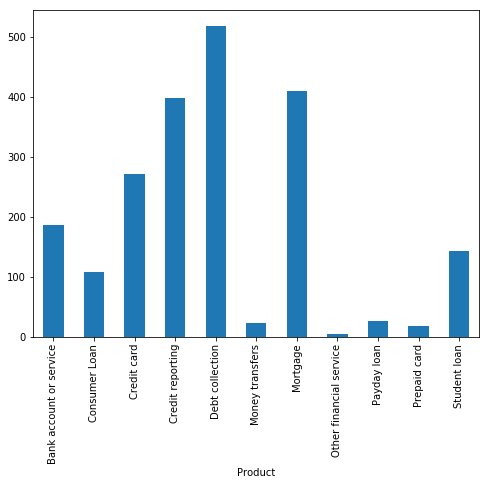

In [48]:
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [49]:
### Used The bag of word model to calculate the frequency of the words in text.
### Applied feature extraction in sklearn library. "http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html"

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

'''
- stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.
- ngram_range : tuple (min_n, max_n). All values such that min_n <= n <= max_n will be used.
- min_df is the minimum numbers of documents a word must be present in to be kept.

'''
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.Product_id
features.shape



(2102, 6045)

In [50]:
product_id_df = df[['Product', 'Product_id']].drop_duplicates().sort_values('Product_id')
product_to_id = dict(product_id_df.values)
id_to_product = dict(product_id_df[['Product_id', 'Product']].values)

### Compute chi-square test to find the terms that are the most correlated with each of the products:
from sklearn.feature_selection import chi2
N = 2
for Product, Product_id in sorted(product_to_id.items()):
    features_chi2 = chi2(features, labels == Product_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  
  

# 'Bank account or service':
  . Most correlated unigrams:
. deposited
. atm
  . Most correlated bigrams:
. overdraft fees
. checking account
# 'Consumer Loan':
  . Most correlated unigrams:
. car
. vehicle
  . Most correlated bigrams:
. personal loan
. ally financial
# 'Credit card':
  . Most correlated unigrams:
. citi
. card
  . Most correlated bigrams:
. annual fee
. credit card
# 'Credit reporting':
  . Most correlated unigrams:
. experian
. equifax
  . Most correlated bigrams:
. information credit
. credit report
# 'Debt collection':
  . Most correlated unigrams:
. collection
. debt
  . Most correlated bigrams:
. debt collector
. collection agency
# 'Money transfers':
  . Most correlated unigrams:
. paypal
. western
  . Most correlated bigrams:
. western union
. send money
# 'Mortgage':
  . Most correlated unigrams:
. modification
. mortgage
  . Most correlated bigrams:
. mortgage company
. loan modification
# 'Other financial service':
  . Most correlated unigrams:
. contracted


Model validation:

After transforming the “Consumer complaint narrative” into a vector of numbers, we predict the unseen “Consumer complaint narrative” on what "Product" they fall.

C:\Users\Amy Le - PC\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Amy Le - PC\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Amy Le - PC\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Amy Le - PC\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 4 members, 

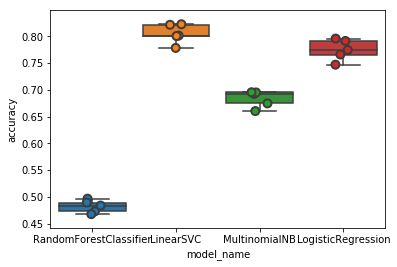

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [53]:
cv_df.groupby('model_name').accuracy.mean()
###LinearSVC and Logistic Regression perform better than the other two classifiers.

model_name
LinearSVC                 0.804869
LogisticRegression        0.774887
MultinomialNB             0.683559
RandomForestClassifier    0.481877
Name: accuracy, dtype: float64

Model evaluation:
We will look at the Confusion Matrix to see the discrepancies b/t the predicted values and the actual values

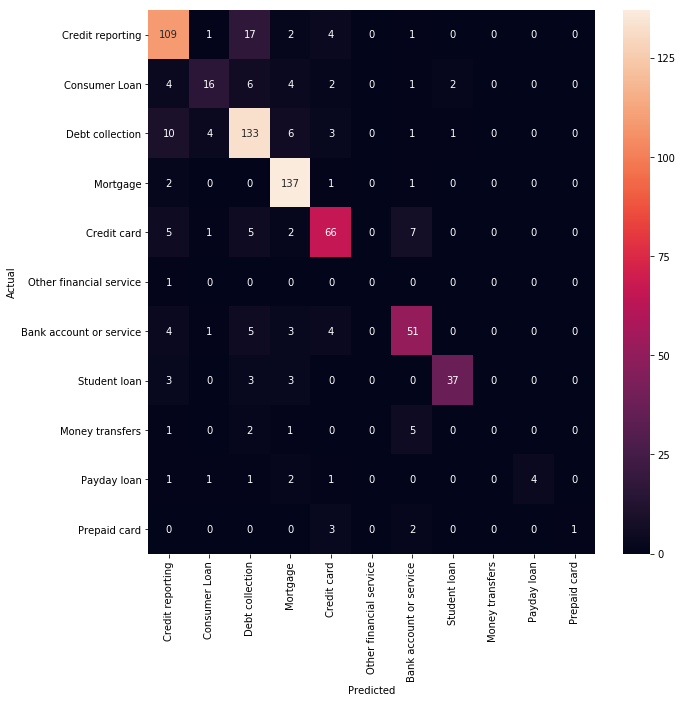

In [55]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=product_id_df.Product.values, yticklabels=product_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The plot shows that there are some misclassifications, but most predicted labels = actual labels


In [56]:
from IPython.display import display
for predicted in product_id_df.Product_id:
    for actual in product_id_df.Product_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_product[actual], id_to_product[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
            print('')

'Debt collection' predicted as 'Credit reporting' : 10 examples.


,Product,Consumer_complaint_narrative
6987,Debt collection,Also collections refuses to stop reporting to ...
255,Debt collection,I have asked real time solutions several times...
2238,Debt collection,Original Institution XXXX XXXX which has been ...
6948,Debt collection,"This company, AFNI , Inc., has added a collect..."
9321,Debt collection,I have bills on my credit report I have nothin...
4431,Debt collection,someone tried getting credit information and i...
1257,Debt collection,currently reporting XXXX invalid debts based o...
16,Debt collection,This complaint is in regards to Square Two Fin...
4023,Debt collection,I have contacted Portfolio several times to as...
7487,Debt collection,called with voicemail saying they would contac...



'Credit reporting' predicted as 'Debt collection' : 17 examples.


,Product,Consumer_complaint_narrative
2299,Credit reporting,I have disputed with the credit bureaus a coll...
1864,Credit reporting,On my Experian account there is a company repo...
889,Credit reporting,Credit bureaus are reporting my former address...
9546,Credit reporting,According to the Fair Credit Reporting section...
2731,Credit reporting,Collection company has stated they have asked ...
8550,Credit reporting,"In 2007, I was a victim of identity theft. As ..."
358,Credit reporting,I mailed out a letter and followed the instruc...
525,Credit reporting,I sent the same letter to all XXXX credit bure...
8986,Credit reporting,I was trying to print my credit report and the...
2793,Credit reporting,I sent Capital One a disputed and validation l...


In [57]:
###Some of the misclassified complaints are complaints that touch on more than one subjects (for example, complaints involving both credit card and credit report). 
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                         precision    recall  f1-score   support

       Credit reporting       0.78      0.81      0.80       134
          Consumer Loan       0.67      0.46      0.54        35
        Debt collection       0.77      0.84      0.81       158
               Mortgage       0.86      0.97      0.91       141
            Credit card       0.79      0.77      0.78        86
Other financial service       0.00      0.00      0.00         1
Bank account or service       0.74      0.75      0.74        68
           Student loan       0.93      0.80      0.86        46
        Money transfers       0.00      0.00      0.00         9
            Payday loan       1.00      0.40      0.57        10
           Prepaid card       1.00      0.17      0.29         6

            avg / total       0.79      0.80      0.79       694



C:\Users\Amy Le - PC\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
